In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 27 09:40:41 2021

@author: Johanna

pointnet from https://github.com/myx666/pointnet-in-pytorch/blob/master/pointnet.pytorch/dataset.py
"""


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
#from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import pandas as pd
import torch.optim as optim


class PointNetCls(nn.Module):
    def __init__(self, k=16):
        super(PointNetCls, self).__init__()
        self.conv1 = torch.nn.Conv1d(npoints, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(k)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        x = F.relu(self.bn6(self.dropout(x)))
        return F.log_softmax(x, dim=1)
   
nclouds = 20000
npoints = 100

# The point clouds
normal = torch.randn(nclouds, npoints, 3)
uniform = torch.rand(nclouds, npoints, 3)
trainset = torch.cat((normal, uniform))

# Labels
zeros = torch.zeros(nclouds, dtype=torch.long)
ones = torch.ones(nclouds, dtype=torch.long)
labels = torch.cat((zeros, ones))

dataset = TensorDataset(trainset, labels)
# Creating the batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)


net = PointNetCls(k=2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Testing clouds

ncloudstest = 20000
npointstest = 100

# The point clouds
normaltest = torch.randn(ncloudstest, npointstest, 3)
uniformtest = torch.rand(ncloudstest, npointstest, 3)
testset = torch.cat((normaltest, uniformtest))

# Labels
zeros = torch.zeros(ncloudstest, dtype=torch.long)
ones = torch.ones(ncloudstest, dtype=torch.long)
labels = torch.cat((zeros, ones))
#print(labels.view(-1,2).size())


testset = TensorDataset(testset, labels)
# Creating the batches
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last=True)

train_loss = []
test_loss = []
test_accuracy = []
train_accuracy = []

def test_lossfun():
    correct = 0
    total = 0
    counter, loss = 0, 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = net(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            counter += 1
    return correct / total, loss / counter

def train_accfun():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total#, criterion(net())

trainep_loss = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0.0
    ep_count = 0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 32 == 31:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 32))
            train_loss.append(running_loss/32)
            #test_loss.append(test_lossfun()[1])
            running_loss = 0.0
        epoch_loss += loss.item()
        ep_count += 1

            
            
    test_accuracy.append(test_lossfun()[0])
    train_accuracy.append(train_accfun())
            
    print('[%d, %5d] ep_loss: %.3f' %
                  (epoch + 1, i + 1, epoch_loss / ep_count), ep_count)
    trainep_loss.append(epoch_loss/ep_count)
    test_loss.append(test_lossfun()[1])
    epoch_loss = 0.0
    ep_count = 0

print('Finished Training')


#Testing


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,    32] loss: 0.400
[1,    64] loss: 0.376
[1,    96] loss: 0.360
[1,   128] loss: 0.357
[1,   160] loss: 0.346
[1,   192] loss: 0.336
[1,   224] loss: 0.322
[1,   256] loss: 0.319
[1,   288] loss: 0.311
[1,   320] loss: 0.301
[1,   352] loss: 0.314
[1,   384] loss: 0.298
[1,   416] loss: 0.292
[1,   448] loss: 0.279
[1,   480] loss: 0.284
[1,   512] loss: 0.273
[1,   544] loss: 0.266
[1,   576] loss: 0.263
[1,   608] loss: 0.259
[1,   640] loss: 0.262
[1,   672] loss: 0.247
[1,   704] loss: 0.256
[1,   736] loss: 0.246
[1,   768] loss: 0.245
[1,   800] loss: 0.247
[1,   832] loss: 0.235
[1,   864] loss: 0.249
[1,   896] loss: 0.234
[1,   928] loss: 0.231
[1,   960] loss: 0.228
[1,   992] loss: 0.238
[1,  1024] loss: 0.251
[1,  1056] loss: 0.224
[1,  1088] loss: 0.229
[1,  1120] loss: 0.228
[1,  1152] loss: 0.204
[1,  1184] loss: 0.191
[1,  1216] loss: 0.183
[1,  1248] loss: 0.185
[1,  1250] ep_loss: 0.271 1250
[2,    32] loss: 0.179
[2,    64] loss: 0.185
[2,    96] loss: 0.181
[2,

[9,  1120] loss: 0.065
[9,  1152] loss: 0.076
[9,  1184] loss: 0.057
[9,  1216] loss: 0.066
[9,  1248] loss: 0.064
[9,  1250] ep_loss: 0.063 1250
[10,    32] loss: 0.073
[10,    64] loss: 0.052
[10,    96] loss: 0.071
[10,   128] loss: 0.073
[10,   160] loss: 0.068
[10,   192] loss: 0.063
[10,   224] loss: 0.047
[10,   256] loss: 0.071
[10,   288] loss: 0.062
[10,   320] loss: 0.053
[10,   352] loss: 0.063
[10,   384] loss: 0.055
[10,   416] loss: 0.051
[10,   448] loss: 0.073
[10,   480] loss: 0.054
[10,   512] loss: 0.066
[10,   544] loss: 0.062
[10,   576] loss: 0.050
[10,   608] loss: 0.060
[10,   640] loss: 0.061
[10,   672] loss: 0.072
[10,   704] loss: 0.053
[10,   736] loss: 0.063
[10,   768] loss: 0.062
[10,   800] loss: 0.051
[10,   832] loss: 0.062
[10,   864] loss: 0.054
[10,   896] loss: 0.062
[10,   928] loss: 0.072
[10,   960] loss: 0.048
[10,   992] loss: 0.064
[10,  1024] loss: 0.075
[10,  1056] loss: 0.056
[10,  1088] loss: 0.075
[10,  1120] loss: 0.059
[10,  1152] lo

[18,   448] loss: 0.068
[18,   480] loss: 0.042
[18,   512] loss: 0.059
[18,   544] loss: 0.061
[18,   576] loss: 0.068
[18,   608] loss: 0.063
[18,   640] loss: 0.044
[18,   672] loss: 0.054
[18,   704] loss: 0.056
[18,   736] loss: 0.062
[18,   768] loss: 0.060
[18,   800] loss: 0.049
[18,   832] loss: 0.063
[18,   864] loss: 0.049
[18,   896] loss: 0.055
[18,   928] loss: 0.051
[18,   960] loss: 0.060
[18,   992] loss: 0.060
[18,  1024] loss: 0.057
[18,  1056] loss: 0.059
[18,  1088] loss: 0.056
[18,  1120] loss: 0.054
[18,  1152] loss: 0.056
[18,  1184] loss: 0.060
[18,  1216] loss: 0.056
[18,  1248] loss: 0.062
[18,  1250] ep_loss: 0.057 1250
[19,    32] loss: 0.063
[19,    64] loss: 0.049
[19,    96] loss: 0.057
[19,   128] loss: 0.060
[19,   160] loss: 0.062
[19,   192] loss: 0.058
[19,   224] loss: 0.046
[19,   256] loss: 0.055
[19,   288] loss: 0.054
[19,   320] loss: 0.054
[19,   352] loss: 0.061
[19,   384] loss: 0.051
[19,   416] loss: 0.060
[19,   448] loss: 0.063
[19,   4

[26,  1056] loss: 0.060
[26,  1088] loss: 0.055
[26,  1120] loss: 0.049
[26,  1152] loss: 0.058
[26,  1184] loss: 0.060
[26,  1216] loss: 0.053
[26,  1248] loss: 0.064
[26,  1250] ep_loss: 0.057 1250
[27,    32] loss: 0.058
[27,    64] loss: 0.051
[27,    96] loss: 0.046
[27,   128] loss: 0.052
[27,   160] loss: 0.052
[27,   192] loss: 0.053
[27,   224] loss: 0.071
[27,   256] loss: 0.044
[27,   288] loss: 0.054
[27,   320] loss: 0.058
[27,   352] loss: 0.061
[27,   384] loss: 0.066
[27,   416] loss: 0.045
[27,   448] loss: 0.056
[27,   480] loss: 0.060
[27,   512] loss: 0.070
[27,   544] loss: 0.051
[27,   576] loss: 0.057
[27,   608] loss: 0.044
[27,   640] loss: 0.058
[27,   672] loss: 0.052
[27,   704] loss: 0.050
[27,   736] loss: 0.063
[27,   768] loss: 0.056
[27,   800] loss: 0.054
[27,   832] loss: 0.058
[27,   864] loss: 0.055
[27,   896] loss: 0.055
[27,   928] loss: 0.060
[27,   960] loss: 0.053
[27,   992] loss: 0.067
[27,  1024] loss: 0.052
[27,  1056] loss: 0.062
[27,  10

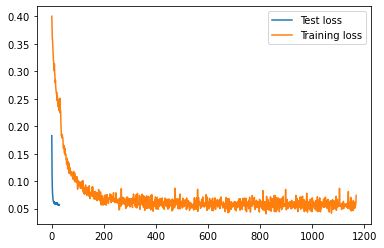

In [2]:
import matplotlib.pyplot as plt
plt.plot(test_loss, label = "Test loss")
plt.plot(train_loss, label = "Training loss")
plt.show
plt.legend()

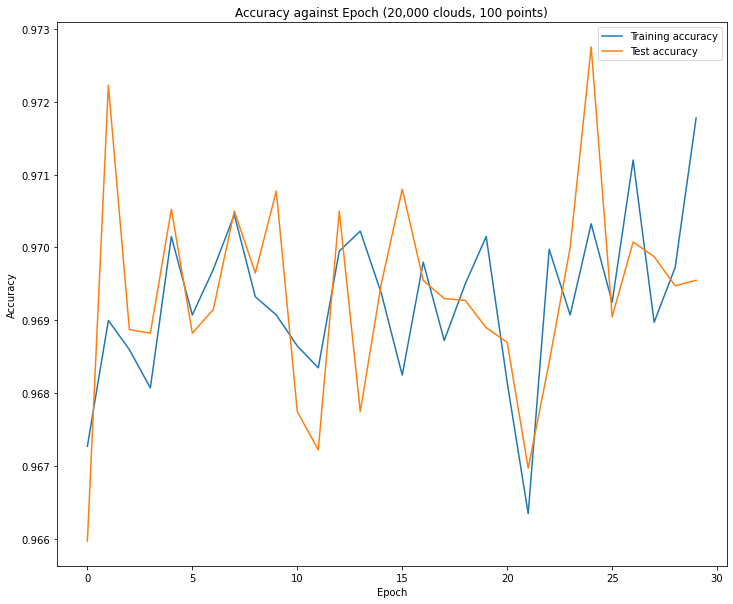

In [3]:
plt.figure(figsize=(12,10))
plt.title('Accuracy against Epoch (20,000 clouds, 100 points)') 
plt.xlabel('Epoch')                                              
plt.ylabel('Accuracy') 
plt.plot(test_accuracy, label = "Training accuracy")
plt.plot(train_accuracy, label = "Test accuracy")
plt.legend()

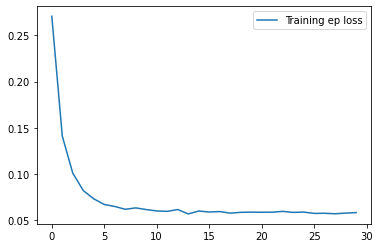

In [4]:
#plt.plot(test_accuracy, label = "Training accuracy")
plt.plot(trainep_loss, label = "Training ep loss")
plt.show
plt.legend()

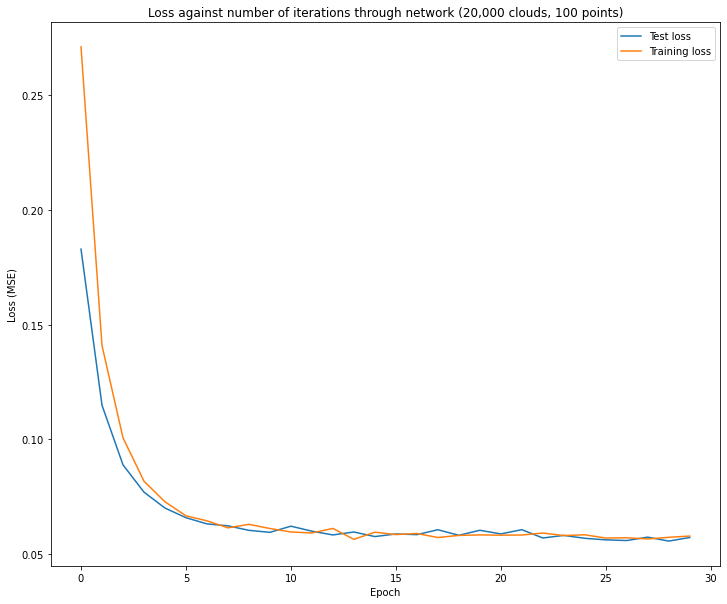

In [7]:
plt.figure(figsize=(12,10))
plt.title('Loss against number of iterations through network (20,000 clouds, 100 points)') 
plt.xlabel('Epoch')                                              
plt.ylabel('Loss (MSE)') 
plt.plot(test_loss, label = "Test loss")
plt.plot(trainep_loss, label = "Training loss")
plt.legend()

In [ ]:
#output = net(Test_load)
normal = torch.randn(nclouds, npoints, 2)
uniform = torch.rand(nclouds, npoints, 2)
print(normal.size(), uniform.size())

In [ ]:
gaussian = torch.distributions.MultivariateNormal(torch.ones(3),torch.eye(3))
gaussian.sample()

In [ ]:
uniform = torch.distributions.uniform.Uniform([0,0],[1,1])
uniform.sample()